In [56]:
from impala.dbapi import connect
from impala.util import as_pandas
import re 
#get data
def get_data(sql):
    conn = connect(host = '10.1.169.3',port = 10000, auth_mechanism = 'PLAIN')
    cursor = conn.cursor()
    cursor.execute(sql)
    df = as_pandas(cursor)
    return df
#define col names
def col_names():
    col_names = []
    #add time
    #col_names = ['dt']
    for i in range(1,263):
        col_name = "F"+str(i)
        col_names.append(col_name)
    return col_names
#define convert
def convert_str_num(str):
    str = str.strip()
    if str.isalpha() or len(str) == 0:
        return 0
    else:
        return int(re.findall("\d+",str)[0])
def convert_true_false(str):
    if str == 'true':
        out = 2
    elif str == 'false':
        out = 1
    else:
        out = 0
    return out
def convert_F51(str):
    list = ["Review",'Accept','Reject']
    if str in list:
        out = list.index(str)+1
    else:
        out = 0
    return out
def convert_reject(str):
    list = ["reject",'reference','pass']
    if str in list:
        out = list.index(str)+1
    else:
        out = 0
    return out
def convert_sex(str):
    list = [u"男",u"女"]
    if str in list:
        out = list.index(str)+1
    else:
        out = 0
    return out
def convert_labels(labels):
    if labels  == 0:
        out = 0
    elif labels >0:
        out = 1
    return out
def convert_ul(str):
    if str == 'ul':
        out = 1
    else:
        out = 0
    return out

In [9]:
df_04 = get_data("select * from tmp.cebai_all_data_04")

In [10]:
df = get_data("select * from tmp.cebai_all_data_0203")

In [20]:
import pandas as pd
def get_Y_X(df):
    df_copy = df.copy()
    df_Y = df_copy['labels'].to_frame(name = 'Y')
    #del df_copy[['labels','aid','uid','dt']]
    #save dt
    df_Y['Y'] = df_Y['Y'].map(convert_labels)
    df_copy.drop(df.columns[[0,1,2,3]],axis=1, inplace=True)
    df_X = df_copy
    df_X.columns = col_names()
    return df_Y,df_X
#map categorical variable
def map_X(df_x):
    df_x['F18'] = df_x['F18'].map(convert_true_false)
    df_x['F51'] = df_x['F51'].map(convert_F51)
    df_x['F58'] = df_x['F58'].map(convert_str_num)
    df_x['F84'] = df_x['F84'].map(convert_str_num)
    df_x['F85'] = df_x['F85'].map(convert_str_num)
    df_x['F87'] = df_x['F87'].map(convert_reject)
    df_x['F88'] = df_x['F88'].map(convert_str_num)
    df_x['F130'] = df_x['F130'].map(convert_str_num)
    df_x['F135'] = df_x['F135'].map(convert_str_num)
    df_x['F141'] = df_x['F141'].map(convert_sex)
    df_x['F145'] = df_x['F145'].map(convert_true_false)
    df_x['F254'] = df_x['F254'].map(convert_str_num)
    df_x['F257'] = df_x['F257'].map(convert_true_false)
    df_x['F259'] = df_x['F259'].map(convert_str_num)
    #add 
    wrong_list = ['F2','F13','F89','F91','F144','F256']
    for wrong in wrong_list:
        df_x[wrong] = df_x[wrong].map(convert_str_num)
    #add
    df_x['F119'] = df_x['F119'].map(convert_ul)
    df_x['F120'] = df_x['F120'].map(convert_ul)
    return df_x
def drop_X(df_x):
    del df_x['F79']
    del df_x['F83']
    del df_x['F124']
    del df_x['F125']
    del df_x['F8']
    return df_x
def dummies_X_one(df_x,col_name):
    df_x_f = pd.get_dummies(df_x[col_name],prefix = col_name )
    del df_x[col_name]
    df_x = pd.concat([df_x,df_x_f],axis = 1)
    return df_x
def dummies_X_all(df_x):
    col_names = ['F18','F51','F87','F141','F145','F257']
    for name in col_names:
        df_x = dummies_X_one(df_x,name)
    return df_x
def get_fix_X(df_x):
    df_x = map_X(df_x)
    df_x = drop_X(df_x)
    #df_x = dummies_X_all(df_x)
    return df_x

In [21]:
ty,yx = get_Y_X(df)

In [22]:
tx = get_fix_X(yx)

In [23]:
colnames = tx.columns

In [24]:
def str_float(str):
    return float(str)
for name in colnames:
    try:
        tx[name].map(str_float)
    except Exception as e:
        print(e)
        print(name)

In [26]:
import pandas as pd
def get_df_online(df):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy.dt >='2017-02-01') & (df_copy.dt <='2017-03-15')]
    return df_copy
def get_df_offline(df):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy.dt >'2017-03-15') & (df_copy.dt < '2017-04-01')]
    return df_copy

In [27]:
#nomolize
from sklearn import preprocessing
def normalize(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled)
    return df_normalized
    

In [28]:
#set Parameter 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
def set_estimators():
    df_online = get_df_online(df)
    y,X = get_Y_X(df_online)
    X = get_fix_X(X)
    #y = normalize(y)
    #X = normalize(X)
    X,xTest,y,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.2,random_state = 520)
    param_test1 = {'max_features':range(3,11,2)}
    gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 1000,min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
    gsearch1.fit(X,y)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

In [54]:
#train
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plot
import numpy as np
from math import sqrt,fabs,exp
def train_online():
    df_online = get_df_online(df)
    y,X = get_Y_X(df_online)
    X = get_fix_X(X)
    #y = normalize(y)
    #X = normalize(X)
    xTrain,xTest,yTrain,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.2,random_state = 520)
    rf = ensemble.RandomForestClassifier(n_estimators=5000,max_depth =13,max_features = 11,min_samples_leaf=1,oob_score = True,n_jobs = -1,random_state = 531,class_weight = 'auto')
    rf.fit(xTrain,yTrain)
    print("online----------oob_score:%f" % rf.oob_score_)
    prediction = rf.predict_proba(xTest)
    auc = roc_auc_score(yTest,prediction[:,1:2])
    print ("online-------AUC Score (test):%f" % auc)
    return rf
def train_offline(rf):
    df_offline = get_df_offline(df)
    y,X = get_Y_X(df_offline)
    X = get_fix_X(X)
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict_proba(xTest)
    auc = roc_auc_score(yTest,prediction[:,1:2])
    print("offline --------AUC Score (test):%f" %auc)
    ypred = rf.predict(xTest)
    ks = ks_2samp(yTest, ypred)
    print( ks)
    #ks1 = ks_2samp(ypred[yTest==1], ypred[yTest!=1])
    #print(ks1)
    ks2 = ks_2samp(yTest,prediction[:,1:2].ravel())
    print(ks2)
def show_auc_train():
    y,X = get_Y_X(df)
    X = get_fix_X(X)
    #y = normalize(y)
    #X = normalize(X)
    xTrain,xTest,yTrain,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.3,random_state = 520)
    auc = []
    nTreelist = range(50,2000,50)
    for iTrees in nTreelist:
        depth = None
        maxFeat = 8
        rocksVMinesRFModel = ensemble.RandomForestClassifier(n_estimators=iTrees,max_depth =depth,max_features = maxFeat,oob_score = False,random_state = 531)
        rocksVMinesRFModel.fit(xTrain,yTrain)
        prediction = rocksVMinesRFModel.predict_proba(xTest)
        aucCalc = roc_auc_score(yTest,prediction[:,1:2])
        print(iTrees+'---'+aucCalc)
        auc.append(aucCalc)
    #plot.plot(nTreeList,auc)
    #plot.xlabel("number of tress in ensembel")
    #plot.xlabel("area under roc curve - auc")
    #plot.show()
    return nTreelist,auc
def plot_ensemble_auc(nTreeList,auc):
    plot.plot(nTreeList,auc)
    plot.xlabel("number of tress in ensembel")
    plot.xlabel("area under roc curve - auc")
    plot.show()
def plot_feature_importance(rf,colnames):
    featureImportance = rf.feature_importances_
    featureImportance = featureImportance / featureImportance.max()
    #plot importnace of top30
    idxSorted = np.argsort(-featureImportance)[0:30]
    #idxTemp = np.argsort(-featureImportance) [::-1]
    #print(idxTemp)
    barpos = np.arange(idxSorted.shape[0]) + .5
    plot.barh(barpos,featureImportance[idxSorted],align = 'center')
    plot.yticks(barpos,colnames[idxSorted])
    print(colnames[idxSorted])
    plot.xlabel('variable importance')
    plot.show()
    return plot

In [30]:
#ks
import numpy as np
import pandas as pd
from collections import Counter
def ks_value(pred,true,n):
    score = (1.-pred)*1000
    index = score.argsort()
    score_sort = np.sort(score)
    true_sort = true[index]
    len_num = pred.size
    add = int(len_num/n)
    out = []
    for i in get_split_len(len_num,n):
        if i == get_split_len(len_num,n)[-1]:
            good_num,bad_num,total = get_good_bad(true_sort,i,-1)
            min_value,max_value = get_max_min(score_sort,i,-1)
            temp = [min_value,max_value,total,bad_num,good_num]
        else:
            good_num,bad_num,total = get_good_bad(true_sort,i,i+add)
            min_value,max_value = get_max_min(score_sort,i,i+add)
            temp = [min_value,max_value,total,bad_num,good_num]
        out.append(temp)
    return out
def list_to_dataframe(out):
    df = pd.DataFrame.from_records(out,columns = ["min_value","max_value","total","bad_num","good_num"])
    return df
def get_good_bad(true,startindex,endindex):
    if endindex == -1:
        true_index = true[startindex:]
    else:
        true_index = true[startindex:endindex]
    c = Counter([i for i in true_index])
    total = true_index.size
    return c[0],c[1],total
def get_max_min(pred,startindex,endindex):
    return pred[startindex],pred[endindex]
def get_split_len(len_num,n):
    out = [0]
    add = int(len_num/n)
    index = 0
    for i in range(n-1):
        index += add
        out.append(int(index))
    return out
def get_ksvalue_offline(rf,df):
    df_offline = get_df_offline(df)
    y,X = get_Y_X(df_offline)
    X = get_fix_X(X)
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict_proba(xTest)
    pred = prediction[:,1:2].ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    df.to_csv("D:\project\ksvalue_offline.csv")
    return df
def get_ksvalue_offline_04(rf,df_04):
    y,X = get_Y_X(df_04)
    X = get_fix_X(X)
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict_proba(xTest)
    pred = prediction[:,1:2].ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    df.to_csv("D:\project\ksvalue_offline_04.csv")
    return df   
'''def get_ksvalue_model_train(rf,df):
    df_online = get_df_online(df)
    y,X = get_Y_X(df_online)
    X = get_fix_X(X)
    xTrain,xTest,yTrain,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.2,random_state = 520)
    pred_train = rf.predict_proba(xTrain)
    pred_test = rf.predict_proba(xTest)
    pred_train = pred_train[:,1:2].ravel()
    pred_test = pred_test[:,1:2].ravel()
    #train ksvalue
    out_train = ks_value(pred_train,yTrain,10)
    df_train = list_to_dataframe(out_train)
    df_train.to_csv("D:\project\ksvalue_train.csv")
    #test ksvalue
    out_test = ks_value(pred_test,yTest,10)
    df_test = list_to_dataframe(out_test)
    df_test.to_csv("D:\project\ksvalue_test.csv")
    return df_train,df_test'''
def get_ksvalue_online(rf,df):
    df_online = get_df_online(df)
    y,X = get_Y_X(df_online)
    X = get_fix_X(X)
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict_proba(xTest)
    pred = prediction[:,1:2].ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    df.to_csv("D:\project\ksvalue_online.csv")
    return df

In [31]:
def test(rf):
    df_offline = get_df_offline(df)
    y,X = get_Y_X(df_offline)
    X = get_fix_X(X)
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict(xTest)
    print(yTest)
    print(prediction)

In [36]:
%matplotlib inline

Index(['F86', 'F90', 'F84', 'F88', 'F134', 'F255', 'F4', 'F260', 'F3', 'F111',
       'F103', 'F223', 'F133', 'F85', 'F192', 'F221', 'F250', 'F180', 'F222',
       'F181', 'F105', 'F194', 'F220', 'F179', 'F226', 'F153', 'F34', 'F252',
       'F161', 'F254'],
      dtype='object')


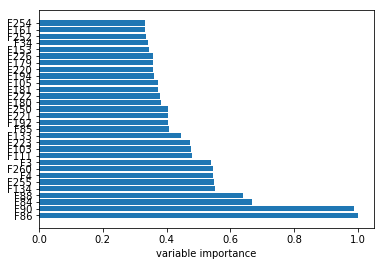

<module 'matplotlib.pyplot' from '/data/program/miniconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [55]:
ty,tX = get_Y_X(df_04)
tX = get_fix_X(tX)
columns = tX.columns
plot_feature_importance(rf,columns)

In [17]:
train_online()

online----------oob_score:0.647070
online-------AUC Score (test):0.643271


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True, random_state=531,
            verbose=0, warm_start=False)

In [20]:
train_online()

online----------oob_score:0.647472
online-------AUC Score (test):0.644024


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=-1, oob_score=True, random_state=531,
            verbose=0, warm_start=False)

In [32]:
rf = train_online()

online----------oob_score:0.743156
online-------AUC Score (test):0.682212


In [33]:
get_ksvalue_online(rf,df)

,min_value,max_value,total,bad_num,good_num
0,92.628436,421.260070,27153,10916,16237
1,421.260070,475.922697,27153,4283,22870
2,475.922697,520.222607,27153,2638,24515
3,520.222607,563.451089,27153,2047,25106
4,563.451089,604.348879,27153,1536,25617
5,604.348879,640.428998,27153,1063,26090
6,640.428998,675.555533,27153,689,26464
7,675.555533,723.076181,27153,451,26702
8,723.076181,816.218983,27153,371,26782
9,816.218983,944.922563,27160,120,27040


In [34]:
get_ksvalue_offline(rf,df)

,min_value,max_value,total,bad_num,good_num
0,294.570969,481.196980,11392,1756,9636
1,481.196980,516.658169,11392,1306,10086
2,516.658169,543.881644,11392,1065,10327
3,543.881644,569.453080,11392,920,10472
4,569.453080,595.169706,11392,838,10554
5,595.169706,621.845677,11392,683,10709
6,621.845677,649.006387,11392,562,10830
7,649.006387,681.517210,11392,404,10988
8,681.517210,755.332572,11392,337,11055
9,755.332572,939.034678,11393,234,11159


In [35]:
get_ksvalue_offline_04(rf,df_04)

,min_value,max_value,total,bad_num,good_num
0,351.897674,520.058641,13042,1833,11209
1,520.058641,547.182860,13042,1453,11589
2,547.182860,568.659594,13042,1242,11800
3,568.659594,588.794418,13042,1171,11871
4,588.794418,609.275130,13042,954,12088
5,609.275130,629.413937,13042,921,12121
6,629.413937,650.231030,13042,691,12351
7,650.231030,676.121335,13042,561,12481
8,676.121335,754.495014,13042,360,12682
9,754.495014,924.990089,13047,328,12719
